# Progetto DSIM - Retrieval

---


Autori: Ginevra Mariani | Lorenzo Mora | Confalonieri Riccardo <br>
E-mail: g.mariani34@campus.unimib.it | l.mora4@campus.unimib.it | r.confalonieri5@campus.unimib.it

L'obiettivo di questo notebook è trovare all’interno di un dataset fornito i 10 volti che somigliano di più ai volti dei componenti del progetto. In particolare:

* I 10 risultati restituiti devono essere ordinati per similarità decrescente

Come dataset si è utilizzato quello [suggerito](https://skydrive.live.com/?cid=1e04f731c1dd71bc&id=1E04F731C1DD71BC!105) che contiene volti di personaggi famosi.

## Import packages

In [ ]:
# scarico i dati necessari per il face detector dlib
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2 
# estraggo lo zip
!bzip2 -dk mmod_human_face_detector.dat.bz2

import os
# rimuovo lo zip che non è più necessario
os.remove('mmod_human_face_detector.dat.bz2')

--2022-02-07 21:44:26--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  3.23MB/s    in 0.2s    

2022-02-07 21:44:26 (3.23 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



In [ ]:
# installo il pacchetto per vggface. Non è necessario, si può creare l'architettura "a mano"
# come nel notebook facerecognition, tuttavia la libreria semplifica di molto i passaggi
!pip install -q keras_vggface
!pip install -q keras_applications

     |████████████████████████████████| 50 kB 2.8 MB/s 


In [ ]:
# campio un import presente nei file di keras_vggface in quanto è stato aggiornato nella
# libreria keras più recente, altrimenti l'import di vggface darebbe errore
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [ ]:
# caricamento e salvataggio su drive
from google.colab import drive

# per estrazione file zip
import zipfile
import shutil

# per gestione label
import numpy as np

# per plot immagini
import matplotlib.pyplot as plt

import dlib # dlib face detector
import time # per calcolo tempo computazione

# per caricare le immagini
from tensorflow.keras.preprocessing import image as kimage
from tensorflow import keras # per utilizzare modelli pretrainati

# per ridimensionare le immagini
import cv2 as cv

# per salvare variabili in file
import pickle

# per gestire vggFace
from keras import  Model
from keras import Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

# per creare l'albero di retrieving
from sklearn.neighbors import KDTree

In [1]:
# caricamento drive
drive.mount('/content/drive', force_remount=True)

# path principale delle cartella
drive_path = '/content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/'

Mounted at /content/drive


## Data Loader
Per poter effettuare correttamente il task di retrieval per prima cosa è necessario caricare tutte le immagini dei volti nei quali voglio trovare i più simili ad una data query. <br>
Gli step di loading in questo caso saranno i seguenti:


1.   Caricamento ed estrazione in locale del file .zip
2.   Crop delle immagini in corrispondenza del volto
3.   Estrazione delle features per tutti i volti individuati, o un certo numero massimo definito. 


Dopo lo step 3, dato l'alto tempo richiesto per la creazione di tutte le features, si è deciso di scrivere su file i dati estratti così da poterli ricaricare immediatamente negli step successivi.

Si procede quindi a scaricare e unzippare in locale il file .zip contenente tutte le immagini di volti famosi.

In [ ]:
def load_zip(file_path, filename, delete_zip = True):
  """
  Funzione che copia in locale i file .zip e li estrai. Il file originale, se
  richiesto, viene eliminato.
  
  :param str file_path: Percorso per lo zip
  :param str filename: Nome dello zip
  :param boolean delete_zip: Indica se eliminare il file .zip scaricato. Default True
  """

  # Scarico sulla macchina locale lo zip
  shutil.copyfile(file_path, filename)
  # estraggo lo zip
  zip = zipfile.ZipFile(filename)
  zip.extractall()
  zip.close()
  # se richiesto cancello lo zip dalla root
  if delete_zip:
    os.remove(filename)

In [ ]:
# scarico lo zip con i volti dei vip e lo estraggo in locale
load_zip(drive_path + 'Data/retrieval/vipdataset.zip', 'vipdataset.zip')

### Funzioni utili
Una volta estratto in locale il file .zip è necessario procedere col punto $2$ e $3$, ovvero con l'individuazione del volto dell'immagini e la creazione delle features corrispondenti al crop del volto. 
Per evitare di salvare su disco anche tutte le immagini croppate, che richiederebbe molto spazio, le due operazioni vengono fatte in maniera consequenziale restituendo quindi le sole features. <br>

Procedo dunque definendo delle funzioni di appoggio per il face detector e per la features extraction.

#### Face detector
Definisco la funzione per trovare il volto nelle immagini ed effettuare il crop. Si è deciso di utilizzare `dlib` come face detector.

In [ ]:
# istanzio il face detector dlib
# richiede la presenza di GPU --> se non c'è da errore
face_detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")

def detect_face(img, zoom = 2, size = (224,224)):
  """
  Funzione che data in input un immagine restituisce in output il crop corrispondente
  al volto presente con dimensione pari a quella richiesta. 
  Qualora fossero presenti più volti verrà utilizzato soltanto il primo individuato.
  Se non vengono individuati volti verrà restituito un oggetto vuoto. 
  
  :param numpy.ndarray img: immagine da croppare
  :param int zoom: Quante volte zoommare l'immagine per individuare i volti. Default 2
  :param int() size: Dimensione dell'immagine da ritornare. Default 224x224

  :return la porzione d'immagine contenente il volto
  :rtype numpy.ndarray or None
  """

  # cerco il volto all'interno dell'immagine. Il secondo parametro indica quante volte
  # zoomare l'immagine per individuare il volto
  faces = face_detector(img, zoom)

  # se non trovo volti ritorno None
  if len(faces) == 0:
    return None
  # se ho trovato almeno un volto lo processo e restituisco il crop
  else:
    for i, d in enumerate(faces):
      left=d.rect.left() #x1
      top=d.rect.top() #y1
      right=d.rect.right() #x2
      bottom=d.rect.bottom() #y2

      # gestisco possibili errori nei valori
      left = max(0, left)
      top = max(0, top)

      # calcolo larghezza e altezza dell'immagine
      width=right-left
      height=bottom-top

      # estraggo il crop
      crop = img[top:top+height, left:left+width]

      # ritorno il volto in dimensioni pari a size
      return cv.resize(crop, size)

#### Features extraction
Definisco le funzioni utili per estrarre le features data un immagine in input. Si è deciso di provare ad utilizzare due modelli neurali:


*   MobileNetV2
*   VGGFace

Ci attendiamo che il primo non restituisca buone features in quanto nel dataset originale di imagenet non sono presenti immagini di volti. Mentre con VGGFace ci aspettiamo risultati più accurati data una determinata query.



Definiamo dunque una funzione per estrarre le feature con MobileNetV2.

In [ ]:
# scarico la rete predefinita MobileNetV2.
# Uso il codice semplificato con include_top=False invece di tagliare a mano sul layer desiderato
base_net = keras.applications.MobileNetV2(
    # uguale alla shape del train_set
    input_shape=(224, 224, 3),
    # non ci interessa il fully_connect perchè non devo classificare
    include_top=False,
    # utilizzo i pesi preaddestrati sul task di imagenet (default weights)
    weights="imagenet",
    # applica il max pooling dopo i layer convoluzionalis
    pooling="max",
)

def mobnet_features(img):
  """
  Funzione che prende in input un'immagine e restituisce in output le 
  features corrispondenti estratte con la rete neurale MobileNet-V2. 
  L'immagine deve essere di dimensioni 224x224 e con canale colori RGB
  
  :param numpy.ndarray img: immagine su cui estrarre le features

  :return le features estratte
  :rtype numpy.ndarray  
  """

  # converto il tipo dell'immagine a numpy array
  x = kimage.img_to_array(img)

  # applico lo stesso preprocessing applicato all'input di mobileNetV2
  x = keras.applications.mobilenet_v2.preprocess_input(x) 

  # aggiungo una dimensione che simula la dim. del batch
  x = np.expand_dims(x, axis = 0)

  # estraggo le features per l'immagine sfruttando la rete pretrainata
  features = base_net.predict(x)

  # l'output di predict ha due dimensioni, la prima è sempre uno quindi non mi serve
  # dato che io impilerò le features estratte su tutte le immagini e quindi
  # è inutile portarmi una dimensione in più
  features = features.flatten()

  return features

9420800/9406464 [==============================] - 0s 0us/step


Definiamo una seconda funzione di appoggio per estrarre le features con VGGFace. Dopo alcuni tentativi si è deciso di utilizzare la prima versione di VGGFace basata sull'architettura VGG. Questo perchè i modelli più recenti di VGGFace come SENET50 e RESNET50 risultavano peggio nel task di retrieval. <br>
La particolare implementazione scelta restituirà in output $512$ features per ogni immagine.

In [ ]:
# definisco la rete per estrazione delle features con vggface
# ALTERNATIVA: model='resnet50' e pooling='max'
base_vggface = VGGFace(include_top=False, pooling = 'avg', input_shape=(224,224,3))
                       
def vggface_features(img):
  """
  Funzione che prende in input un'immagine e restituisce in output le 
  features corrispondenti estratte con la rete neurale VGGFace basata su VGG. 
  L'immagine deve essere di dimensioni 224x224 e con canale colori RGB
  
  :param numpy.ndarray img: immagine su cui estrarre le features

  :return le features estratte
  :rtype numpy.ndarray
  """

  # converto il tipo dell'immagine a numpy array
  x = kimage.img_to_array(img)

  # applico il preprocessing di vggFace
  x = utils.preprocess_input(x, version=1) # Version 2 dato che abbiamo scelto senet50

  # aggiungo una dimensione che simula la dim. del batch
  x = np.expand_dims(x, axis = 0)

  # estraggo le features per l'immagine sfruttando la rete pretrainata
  features = base_vggface.predict(x)
  
  # l'output di predict ha due dimensioni, la prima è sempre uno quindi non mi serve
  # dato che io impilerò le features estratte su tutte le immagini e quindi
  # è inutile portarmi una dimensione in più
  features = features.flatten()

  return features

58925056/58909280 [==============================] - 1s 0us/step


Definiamo anche una funzione di estrazione delle features dummy che non fa altro che ritornare i valori dell'immagine.

In [ ]:
# Dummy feature
def identity(img):
  """
  Funzione dummy che prende in input un'immagine e restituisce in output i valori
  stessi dell'immagine in un flatten array. L'immagine deve essere di dimensioni 
  224x224 e con canale colori RGB
  
  :param numpy.ndarray img: immagine su cui estrarre le features

  :return le features estratte
  :rtype numpy.ndarray
  """
  return kimage.img_to_array(img).flatten()

#### Save features
Definisco due funzioni di appoggio che permettono di salvare su file le features create e ricaricarle in un secondo momento. Così facendo è possibile risparmiare molto tempo e creare le features solo la prima volta.

In [ ]:
def save_data(data, filename):
  """
  Funzione che dato in input un array di dati lo salva su un file.
  
  :param numpy.ndarray or list data: dati da salvare su file.
  :param str filename: percorso in cui salvare il file. Deve includere il nome del file.
  """

  # apro il file
  open_file = open(filename, "wb")
  # scrivo i dati
  pickle.dump(data, open_file)
  # chiudo il file
  open_file.close()



def load_data(filename):
  """
  Funzione che carica i dati presenti in un file. Se non è possibile caricare i dati
  ritorna None.
  
  :param str filename: percorso del file da caricare. Deve includere il nome del file.

  :return I dati caricati
  :rtype numpy.ndarray or list or None
  """

  try:
    # apro il file
    open_file = open(filename, "rb")
    # carico i dati
    loaded_data = pickle.load(open_file)
    # chiudo il file
    open_file.close()

    return loaded_data

  # se non esiste il file ritorno None
  except FileNotFoundError:
     return None

### Creazione dataset
Avendo definito le funzioni di appoggio è possibile combinarle correttamente per creare le features di riferimento per le immagini dei vip a nostra disposizione.
Data la particolare struttura a sottocartelle è necessario implementare dei cicli per iterare sulle varie persone e sulle immagini a disposizione per ogni vip. <br>

**NOTA1:** Qualora il face detector non individuasse alcun volto l'immagine verrà saltata, quindi non verranno create le corrispondenti features

**NOTA2:** In totale si hanno a disposizione oltre $200.000$ immagini di più di $1500$ vip. Creare le features di tutte queste immagini richiederebbe troppo tempo e troppe risorse computazionali, quindi verranno create le features solo di un subset di queste immagini.

In [ ]:
def data_creation(dataset_path, max_img_per_vip = 2147483647, tot_people = 2147483647, 
                  tot_img = 2147483647, feature_extractor=identity):

    """
    Funzione che itera sulla struttura a cartelle ed estrae un certo numero di immagini
    utilizzando uno specifico feature extractor. E' possibile specificare:
      - quante immagini estrarre in totale
      - quanti vip (cartelle) considerare al massimo 
      - quante immagini per singolo vip (cartella)
    

    :param str dataset_path: percorso in cui è presente il dataset con i volti dei vip.
    :param int max_img_per_vip: Numero di immagini da estrarre per ogni vip (cartella). 
                        Default max int (2147483647)
    :param int tot_people: Numero massimo di vip (cartelle) da considerare. 
                           Default max int (2147483647)
    :param int tot_img: Numero massimo di immagini da estrarre in totale. 
                        Default max int (2147483647)    
    :param func feature_extractor: Funzione per estrarre le features. Default identity() 


    :return le features delle immagini e i percorsi alle stesse
    :rtype numpy.ndarray, list
    """

    paths = []
    features = []

    # itero sulla struttura a sottocartelle
    for count_subf, subfold in enumerate(sorted(os.listdir(dataset_path))):
      # se ho già estratto le immagini di più di un certo numero di persone 
      # o un certo numero totale di immagini mi fermo
      if count_subf > tot_people or len(features) > tot_img:
        break
      
      # unisco il subpath con il path della cartella
      subpath = os.path.join(dataset_path, subfold)
      # conto quante immagini ho estratto per il nuovo vip
      count = 0
      # per ogni file nella sottocartella estraggo le features delle immagini
      for fi,f in enumerate(sorted(os.listdir(subpath))):
        # se ho già estratto un certo numero di immagini totali o un certo numero
        # di immagini per questo vip mi fermo e passo al successivo
        if len(features) > tot_img or count >= max_img_per_vip:
          break

        # se il file è un immagine lo processo
        if f.endswith('.jpg'):
            # definisco il path fino all'immagine
            cur_path = os.path.join(subpath, f)

            # Carico l'immagine
            image = cv.imread(cur_path)

            # estraggo il crop del volto
            crop = detect_face(image)

            # se ho trovato un volto ne estraggo le features e salvo il path
            if crop is not None:
              cur_features = feature_extractor(crop)
              # concatena le features correnti a quelle già estratte
              features.append(cur_features)
              # Memorizzo il percorso del file in una lista per accederci poi facilmente
              paths.append(cur_path) 
              # aumento il contatore delle immagini estratte per questo vip
              count = count + 1
            '''
            else:
              print('ERROR: ', cur_path)
            '''
    # ottengo un array di features
    features = np.array(features)
    # ritorna sia le features che il path
    return features, paths

#### MobileNet-V2
Le prime features che verranno create sfruttano la rete preaddestrata di MobileNet-V2. Una volta estratte le features verranno salvate su un file per evitare di doverle ricreare ad ogni avvio del notebook.

In [ ]:
# Se le features sono già state create precedentemente le carico da file, altrimenti le creo nuove e le salvo
X_train_mn = load_data(drive_path +"Model/Retrieval/features_mobilenet.pkl")
paths_mn = load_data(drive_path +"Model/Retrieval/paths_mobilenet.pkl")

# se ho caricato correttamente sia features che path evito di generarli nuovamente
if X_train_mn is None or paths_mn is None:
  # path alla cartella dei volti vip
  vip_path = '/content/thumbnails_features_deduped_publish/'

  start_time = time.time()

  # estraggo le features su un subset delle immagini nella cartella
  # in particolare estraggo massimo 20 immagini per ogni vip
  X_train_mn, paths_mn = data_creation(vip_path, max_img_per_vip=20, 
                                       feature_extractor=mobnet_features)
  
  # visualizzo quanto tempo ci mette per creare le features
  print("--- %s seconds ---" % (time.time() - start_time))


  # salvo le nuove features ed i path corrispondenti
  save_data(X_train_mn, drive_path + "Model/Retrieval/features_mobilenet.pkl")
  save_data(paths_mn, drive_path + "Model/Retrieval/paths_mobilenet.pkl")

--- 3034.4621801376343 seconds ---


In [ ]:
# visualizzo i dati prodotti dalla funzione
print("Numero di elementi:", len(paths_mn))
print("Dimensione delle features:", X_train_mn.shape)

Numero di elementi: 31496
Dimensione delle features: (31496, 1280)


Possiamo notare come per ogni elemento si abbiamo a disposizione $1280$ features, come ci si attendeva da MobileNet-V2. Inoltre dal tempo riportato per la creazione notiamo che ci vuole circa un'ora per estrarre le features dei volti considerati.

#### VGGFace
Effettuaimo la medesima operazione precedente ma in questo caso verrà utilizzato VGGFace come modello neurale per l'estrazione delle features.

In [ ]:
# Se le features sono già state create precedentemente le carico da file, altrimenti le creo nuove e le salvo
X_train_vgg = load_data(drive_path +"Model/Retrieval/features_vggface.pkl")
paths_vgg = load_data(drive_path +"Model/Retrieval/paths_vggface.pkl")

# se ho caricato correttamente sia features che path evito di generarli nuovamente
if X_train_vgg is None or paths_vgg is None:
  start_time = time.time()

  # path alla cartella dei volti vip
  vip_path = '/content/thumbnails_features_deduped_publish/'

  # estraggo le features sun un subset delle immagini nella cartella
  # in particolare estraggo massimo 20 immagini per ogni vip
  X_train_vgg, paths_vgg = data_creation(vip_path, max_img_per_vip=20, 
                                         feature_extractor=vggface_features)
  
  # visualizzo quanto tempo ci mette per creare le features
  print("--- %s seconds ---" % (time.time() - start_time))


  # salvo le nuove features ed i path corrispondenti
  save_data(X_train_vgg, drive_path + "Model/Retrieval/features_vggface.pkl")
  save_data(paths_vgg, drive_path + "Model/Retrieval/paths_vggface.pkl")

--- 4270.880006551743 seconds ---


In [ ]:
# visualizzo i dati prodotti dalla funzione
print("Numero di elementi:", len(paths_vgg))
print("Dimensione delle features:", X_train_vgg.shape)

Numero di elementi: 31496
Dimensione delle features: (31496, 512)


Possiamo notare come per ogni elemento si abbiamo a disposizione $512$ features, come ci si attendeva da VGGFace con architettura basata su avg ed average pooling. Infine, dato che VGGFace è un modello più complesso è possibile notare come la creazione delle features richieda più tempo rispetto a prima.

# Retrieving similar image: mobilenet
Ricerco l'immagine più simile presente nel training set sfruttando la procedura di `kdtree` che è ottimizzata e permette di effettuare una ricerca efficiente. L'algoritmo funziona in questo modo:

1. Divide lo spazio rispetto alla prima dimensione calcolando il mediano sull'asse orizzontale
2. Divide lo spazio rispetto alla seconda dimensione calcolando il mediano sull'asse verticale
3. Continua così per tutte le dimensioni e poi ricomincia dal primo punto.

Così si è creato un albero di ricerca che viene utilizzato per estrarre l'immagine più vicina in modo ottimizzato e senza verificare tutti i punti.

1. Rispetto alla prima dimensione si chiede se la prima coordinata è maggiore o inferiore ed elimina i restanti punti
2. Ripete il punto 1 per tutte le dimensioni.
3. Si arriva ad un solo punto (foglia dell'albero) e quindi è un candidato ad essere uno dei più simili.
4. Si percorre quindi a ritroso l'albero delle decisioni e si calcola la distanza della query rispetto al nodo corrente e si usano una serie di accorgimenti per non calcolarla rispetto a tutti i punti e tutte le dimensioni.

<p align = 'center'>
<img src='https://www.researchgate.net/profile/Juan-Andrade-Cetto/publication/251813225/figure/fig1/AS:341656336388110@1458468626545/A-kd-tree-example-subdivided-data-left-and-the-corresponding-binary-tree-right.png' width = 700, height = 250 />

In [ ]:
%%time
# applico il kdtree per calcolare l'albero basato sulle features di mobilenet
tree_mn = KDTree(X_train_mn)

CPU times: user 7.34 s, sys: 860 ms, total: 8.2 s
Wall time: 8.16 s


Come possiamo notare la creazione dell'albero richiede pochi secondi, trascurabili se si confrontano col tempo richiesto per la creazione delle features. Per questo motivo si è scelto di salvare l'array contenente le features invece dell'albero finale, inoltre questa scelta garantisce di poter cambiare successivamente la struttura per il retrieving senza dover estrarre nuovamente tutte le features ottimizzando così i tempi.

Definisco quindi una funzione che permetta, data un immagine di query, di estrarre le $k$ immagini più simili e visualizzarle a video.

In [ ]:
def get_k_similar_people(img_query, tree, path_target, feature_extractor, K=10):
  """
  Funzione che permette di recuperare le k immagini più simili ad una data immagine
  di query. Le immagini individuate vengono visualizzate a video con nome della persona
  e distanza rispetto alla query. Verranno visualizzate sia le immagini complete
  sia i crop dei soli volti su cui si basano le features.
  

  :param numpy.ndarray img_query: immagine di query.
  :param sklearn.KDTree tree: struttura KDTree che permette di individuare le immagini
                              più simili alla query
  :param list path_target: percorso delle immagini presenti nel tree
  :param func feature_extractor: Funzione per estrarre le features.
  :param int K: Numero di immagini da estrarre. Default 10
  """

  # applico il face detector all'immagine di query
  query_crop = detect_face(img_query)

  # se ho trovato un volto ne estraggo le features e cerco le k img più simili
  if query_crop is not None:
      # estraggo le features
      query_features = feature_extractor(query_crop)

      # simulo la dimensione dal batch
      query_features = np.expand_dims(query_features, axis = 0)

      # eseguo la ricerca della query nell'albero
      distance, idx = tree.query(query_features, k=K)

      # visualizzo la query non croppata
      ax = plt.subplot(1, 2, 1)
      # visualizzo l'immagine
      plt.imshow(img_query)
      # tolgo la visualizzazione degli assi
      plt.axis("off")
      plt.title("Query")

      # visualizzo il crop del volto di query
      ax = plt.subplot(1, 2, 2)
      plt.subplots_adjust(wspace=0.5, hspace = 0.5)
      plt.imshow(query_crop)
      # tolgo la visualizzazione degli assi
      plt.axis("off")
      plt.title("Query cropped")

      plt.show()

      # visualizzo a video le 10 immagini più simili trovate
      for i in range(K):  
        # carico l'immagine in posizione i 
        img = cv.imread(path_target[idx[0][i]])

        # converto i colori in RGB
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # visualizzo l'immagine trovata non croppata
        ax = plt.subplot(1, 2, 1)
        # visualizzo l'immagine
        plt.imshow(img)
        # tolgo la visualizzazione degli assi
        plt.axis("off")
        # estraggo il nome dal path
        name = path_target[idx[0][i]].split('/')[-2]
        str_title = str(i+1) +". " + name + "\ndist: " + str(np.round(distance[0][i], 3))
        plt.title(str_title)

        # visualizzo il crop del volto vip trovato (sono sicuro esista il crop!)
        ax = plt.subplot(1, 2, 2)
        plt.subplots_adjust(wspace=0.5, hspace = 0.5) # aggiusto gli spazi tra immagini
        plt.imshow(detect_face(img))
        # tolgo la visualizzazione degli assi
        plt.axis("off")
        plt.title(str(i+1) +". " + name + '\ncropped')
        plt.show()
  else:
    print("Nessun volto trovato per l'immagine di query")

Viene dunque effettuata per tutti e tre i componenti del gruppo la ricerca dei $10$ volti più simili.

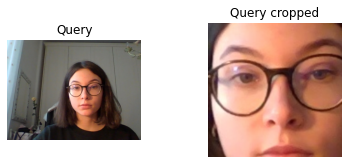

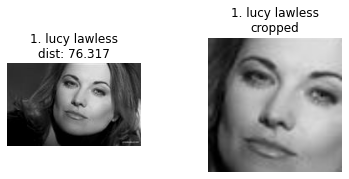

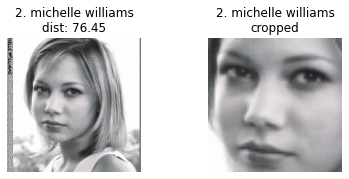

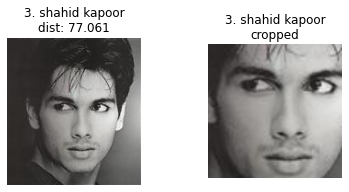

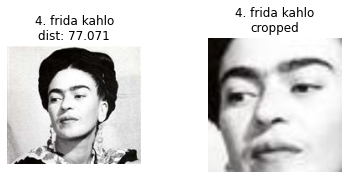

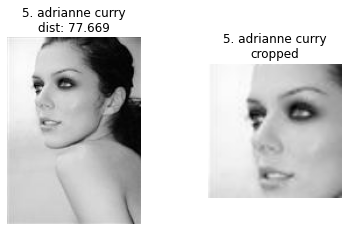

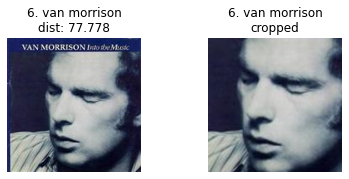

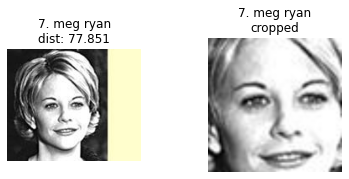

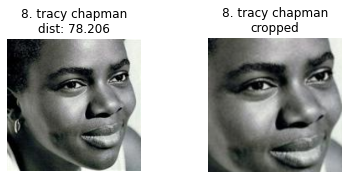

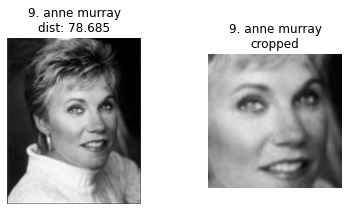

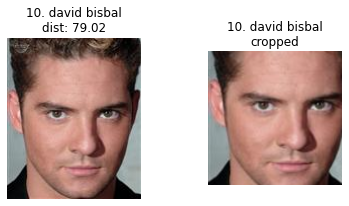

In [ ]:
# carico l'immagine di query per Ginevra
query_img = cv.imread(drive_path + 'Data/retrieval/dataset/Ginevra.jpg')
# converto i colori in RGB
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)

# visualizzo i 10 volti più simili
get_k_similar_people(query_img, tree_mn, paths_mn, mobnet_features)

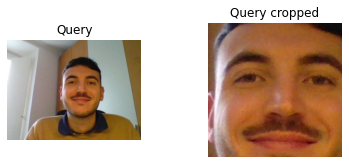

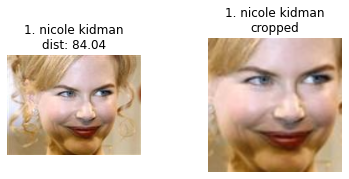

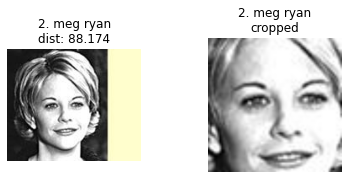

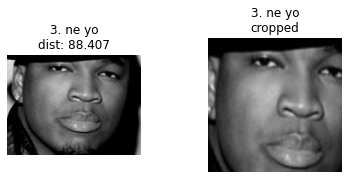

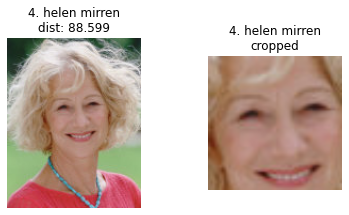

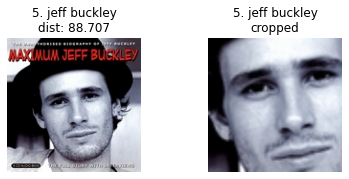

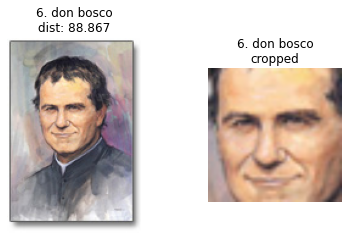

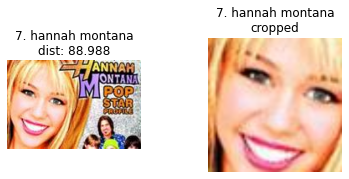

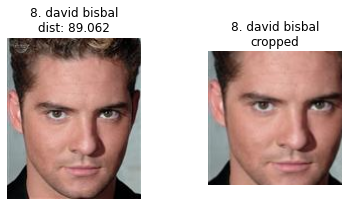

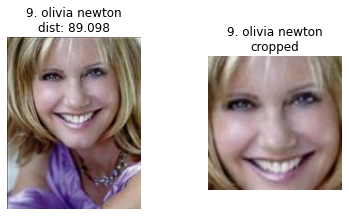

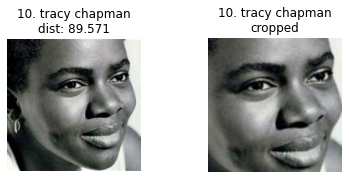

In [ ]:
# carico l'immagine di query per Lorenzo
query_img = cv.imread(drive_path + 'Data/retrieval/dataset/Lorenzo.jpg')
# converto i colori in RGB
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)

# visualizzo i 10 volti più simili
get_k_similar_people(query_img, tree_mn, paths_mn, mobnet_features)

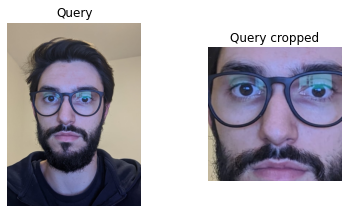

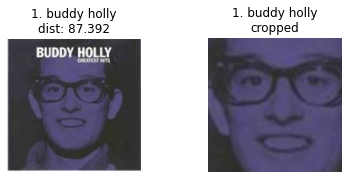

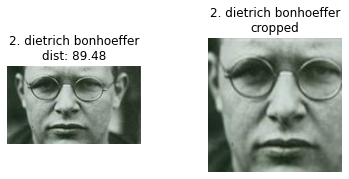

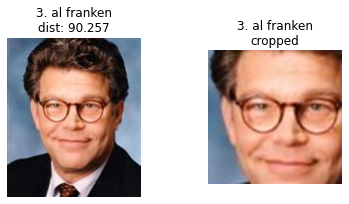

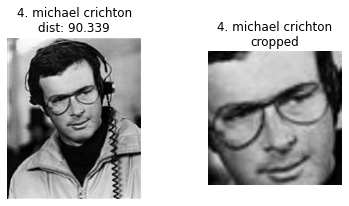

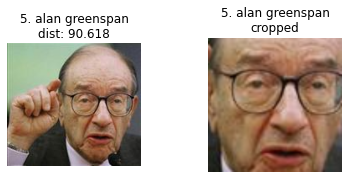

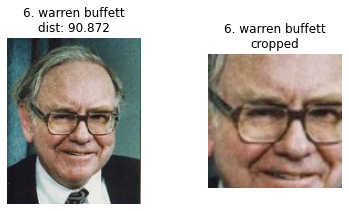

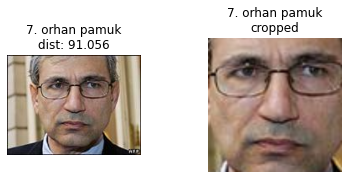

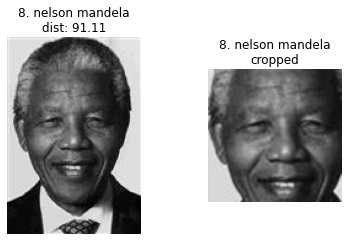

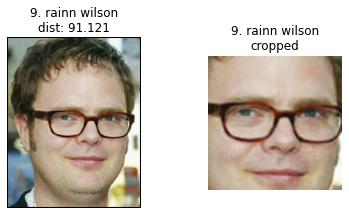

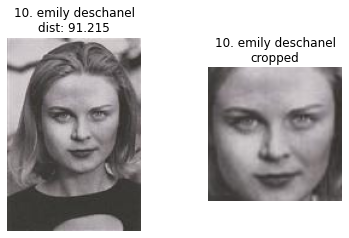

In [ ]:
# carico l'immagine di query per Riccardo
query_img = cv.imread(drive_path + 'Data/retrieval/dataset/Riccardo.jpg')
# converto i colori in RGB
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)

# visualizzo i 10 volti più simili
get_k_similar_people(query_img, tree_mn, paths_mn, mobnet_features)

Osservando i risultati ottenuti con MobileNet-V$2$ possiamo osservare che ci sono alcune similutidini tra l'immagine di query e la prima (in alcuni casi seconda) immagine individuata come più simile. Le successive immagini invece non sembrano essere particolarmente simili alla query. <br>
Più specificatamente:


*   Per Ginevra si può notare come la prima immagine abbia le sopracciglia inarcate in modo simile alla query. 
*   Per Lorenzo la prima immagine ha un espressione simile
* Per Riccardo il retrieving sembra più dovuto alla presenza degli occhiali.

Come ci si aspettava MobileNet-V$2$ non sembra particolarmente adatto a questo task, inoltre spesso con query maschili vengono recuperate immagini femminili di volti simili e viceversa. Non ci si ritiene quindi molto soddisfatti del risultato! Per questo motivo si è provato ad implementare la medesima ricerca con VGGFace come estrattore di features.



# Retrieving similar image: VGGFace
Ricerco l'immagine più simile presente nel training set sfruttando i medesimi passagi precedenti, tuttavia in questo caso uso le features estratte con VGGFace.

In [ ]:
%%time
# applico il kdtree per calcolare l'albero dei nostri dati
tree_vgg = KDTree(X_train_vgg)

CPU times: user 2.74 s, sys: 29.4 ms, total: 2.77 s
Wall time: 2.75 s


Come nel caso precedente l'albero richiede tempi di creazioni poco elevati, quindi si preferisce nuovamente mantenere il file con tutte le features invece che il solo albero. Procedo quindi visualizzando i 10 volti più simili per ciascun componente

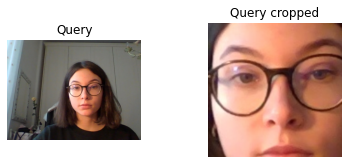

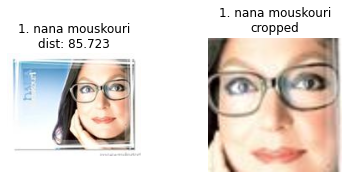

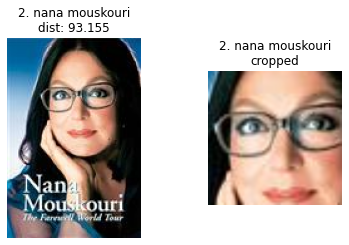

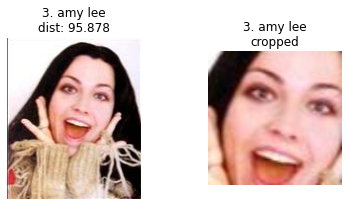

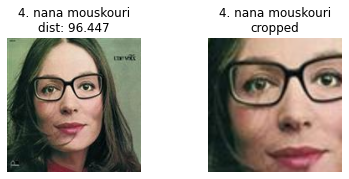

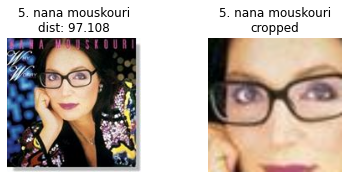

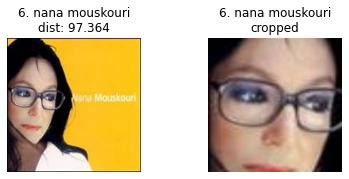

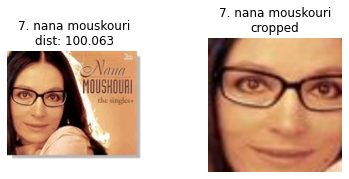

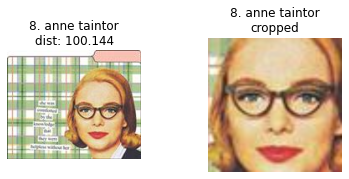

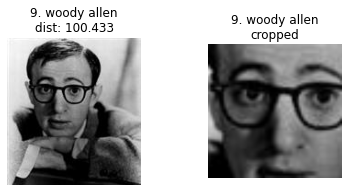

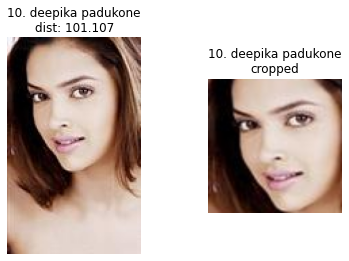

In [ ]:
# carico l'immagine di query per Ginevra
query_img = cv.imread(drive_path + 'Data/retrieval/dataset/Ginevra.jpg')
# converto i colori in RGB
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)

# visualizzo i 10 volti più simili
get_k_similar_people(query_img, tree_vgg, paths_vgg, vggface_features)

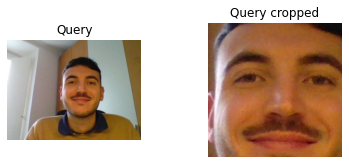

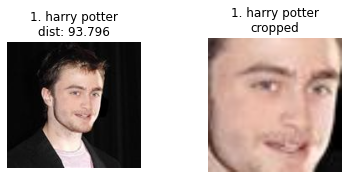

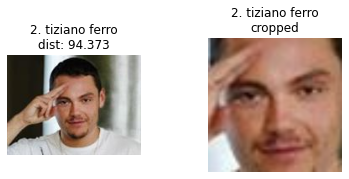

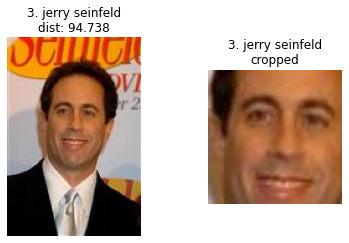

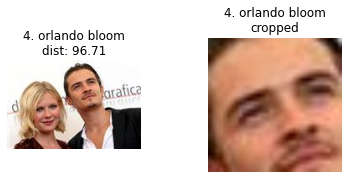

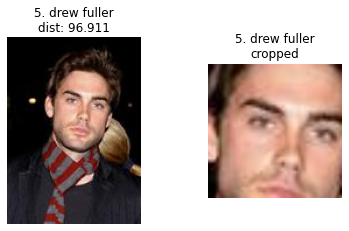

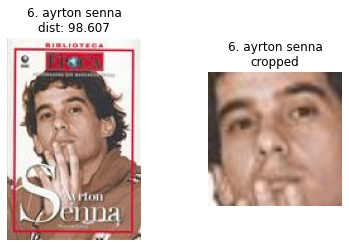

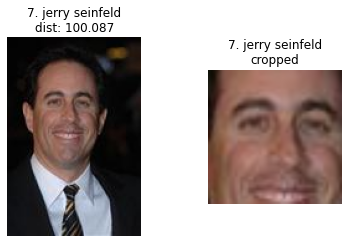

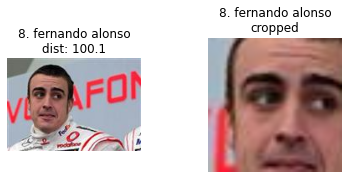

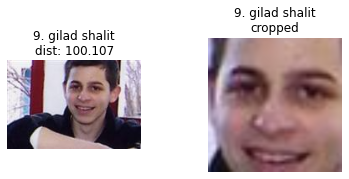

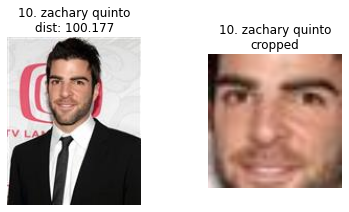

In [ ]:
# carico l'immagine di query per Lorenzo
query_img = cv.imread(drive_path + 'Data/retrieval/dataset/Lorenzo.jpg')
# converto i colori in RGB
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)

# visualizzo i 10 volti più simili
get_k_similar_people(query_img, tree_vgg, paths_vgg, vggface_features)

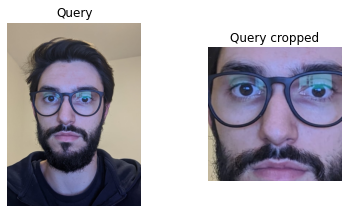

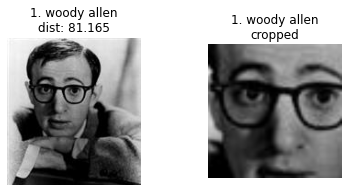

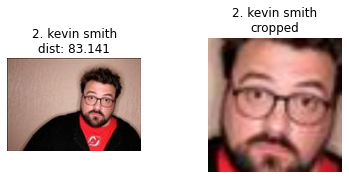

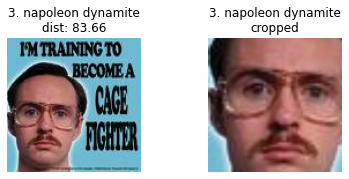

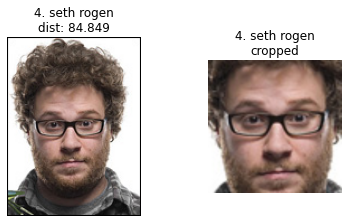

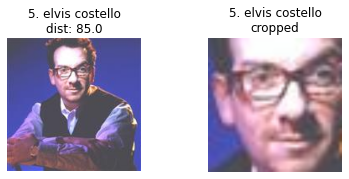

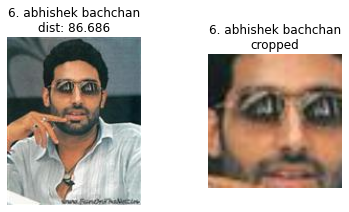

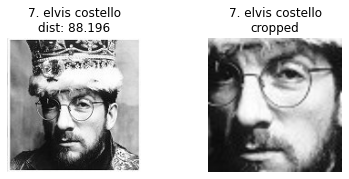

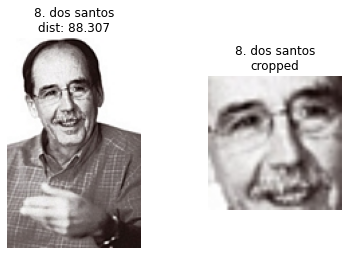

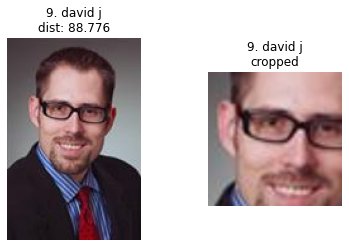

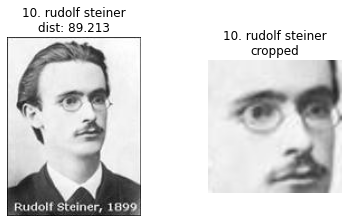

In [ ]:
# carico l'immagine di query per Riccardo
query_img = cv.imread(drive_path + 'Data/retrieval/dataset/Riccardo.jpg')

# converto i colori in RGB
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)

# visualizzo i 10 volti più simili
get_k_similar_people(query_img, tree_vgg, paths_vgg, vggface_features)

Con questo estrattore di features i risultati migliorano molto. Anche le immagini successive alla prima infatti hanno buona somiglianza con la query in input. Inoltre spesso si possono notare somiglianze in più particolari contemporaneamente come occhiali, sopracciglia, naso, espressione, etc...
Infine possiamo notare che soltanto in un caso le immagini recuperate riportano persone del sesso opposto, mentre per tutti gli altri casi nei primi dieci volti più simili viene mantenuto il sesso presente nel volto di query.
Sicuramente questo estrattore, come ci si attendeva, da risultati migliori.

## Considerazioni Finali
In conclusione è possibile osservare che il task risulta essere complesso e richiede un grande sforzo computazionale per creare le features ed estrarre i volti per tutto il dataset di riferimento. Tuttavia l'estrazione e la creazione delle features viene fatta un'unica volta all'inizio e poi rimane costante. Questo può permettere di realizzare estrattori più efficienti che elaborano piccoli batch di immagini per evitare problemi di OOM oppure con esecuzioni parallele su sottoporzioni dell'intero dataset. <br>
Inoltre, come già anticipato, si è preferito salvare le features piuttosto che l'albero finale utilizzato per il retrieving perchè questo garantisce più flessibilita in quanto la creazione dell'albero richiede molto meno tempo e così facendo:


*   E' possibile cambiare l'albero successivamente
*   Nel caso in cui vengano introdotti nuovi volti vip di riferimento non è necessario rieseguire tutto nuovamente ma basta calcolare le features dei nuovi volti ed aggiungere in modalità append al file.

Per quanto riguarda i risultati ottenuti ci si può ritenere abbastanza soddisfatti, sicuramente una miglioria sarebbe quella di considerare tutti i volti a disposizione. Inoltre se si analizza il retrieving di VGGFace per Ginevra si può notare che ci sono più volti riferiti alla stessa persona, questo può essere un risultato non voluto e che quindi potrebbe essere oggetto di migliorie future. <br>
Infine si è notato che la qualità dell'immagine in input, sia per la query che per i volti vip, inficia molto il risultato del retrieving. 



In [2]:
# download notebook in .html extension
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Retrieval/Retrieval.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Retrieval/Retrieval.ipynb to html
[NbConvertApp] Writing 5793894 bytes to /content/drive/MyDrive/Confalonieri_Mariani_Mora_DSIM/Notebook/Retrieval/Retrieval.html
